In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datasets import load_dataset
import evaluate
import pickle
import time
from tqdm.notebook import tqdm
from nltk.corpus import wordnet as wn

tqdm.pandas()

Loading the taxonomy

In [92]:
emb_sh = "_jbEn"
with open(f"../../data/taxonomy/taxonomy_embeddings{emb_sh}.pkl", "rb") as f:
    emb_tax = pickle.load(f)
    emb_tax["name"] = emb_tax["name+definition"].apply(lambda x : x.split(" : ")[0])

In [93]:
from collections import Counter

for nd in emb_tax["name+definition"][:10]:
    w = nd.split(" : ")[0].split(" ")[0]

    pos_l = list()
    for tmp in wn.synsets(w):
            if tmp.name().split('.')[0] == w:
                pos_l.append(tmp.pos())
    cnts = Counter(pos_l).most_common(1)
    if(len(cnts) == 0):
         ty = 'n'
    else :
         ty = cnts[0][0]
    print("w = ", w, ", class=", ty)
    

w =  manage , class= v
w =  supervise , class= n
w =  apply , class= v
w =  control , class= n
w =  identify , class= v
w =  perform , class= v
w =  ensure , class= n
w =  Haskell , class= n
w =  show , class= v
w =  train , class= v


In [94]:
import spacy

nlp = spacy.load("en_core_web_sm")

for nd in emb_tax["name+definition"][:10]:
    text = nd.split(" : ")[0]
    doc = nlp(text) 
    
    # checking if it is a noun or not 
    if(doc[0].tag_ == 'NNP'): 
        print("w = ", text.split(" ")[0], ", class = NN") 
    else: 
        print("w = ", text.split(" ")[0], ", class = V") 

w =  manage , class = V
w =  supervise , class = V
w =  apply , class = V
w =  control , class = NN
w =  identify , class = V
w =  perform , class = V
w =  ensure , class = V
w =  Haskell , class = NN
w =  show , class = V
w =  train , class = V


In [95]:
def format_input(name):
    if(type(name) != 'str' and len(name) == 2):
        defin = ", which consist of : " + name[1]
        name = name[0]
    elif len(name) == 1:
        name = name[0]
        defin = ""
    else :
        defin = ""

    doc = nlp(name) 
    is_noun = doc[0].tag_ == 'NNP'
    return f"i want to learn {'' if is_noun else 'to '}{name}" + defin



ppl_inputs_simple = list(emb_tax["name+definition"]\
                        .apply(lambda x : x.split(" : ")[0])\
                        .progress_apply(format_input))

ppl_inputs_compose = list(emb_tax["name+definition"]\
                        .apply(lambda x : x.split(" : "))\
                        .progress_apply(format_input))

  0%|          | 0/13896 [00:00<?, ?it/s]

  0%|          | 0/13896 [00:00<?, ?it/s]

In [96]:
ppl_inputs_simple

['i want to learn to manage musical staff',
 'i want to learn to supervise correctional procedures',
 'i want to learn to apply anti-oppressive practices',
 'i want to learn control compliance of railway vehicles regulations',
 'i want to learn to identify available services',
 'i want to learn to perform toxicological studies',
 'i want to learn to ensure coquille uniformity',
 'i want to learn Haskell',
 'i want to learn to show initiative',
 'i want to learn to train staff to reduce food waste',
 'i want to learn to apply diplomatic principles',
 'i want to learn to lead police investigations',
 'i want to learn to handle fish harvesting waste',
 'i want to learn to develop energy saving concepts',
 'i want to learn to perform street interventions in social work',
 'i want to learn to work with soloists',
 'i want to learn to sport and exercise medicine',
 'i want to learn to conduct research on flora',
 'i want to learn to install heat pump',
 'i want to learn to design biomass ins

In [101]:
perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(model_id="gpt2", predictions=ppl_inputs_simple)

Using pad_token, but it is not set yet.


  0%|          | 0/869 [00:00<?, ?it/s]

In [102]:
import json
with open("ppl_inputs_simple.json", "w") as f:
    json.dump(results, f)

In [103]:
results.update({'input': ppl_inputs_simple, "skill": list(emb_tax.name.values)})

In [104]:
F = pd.DataFrame(results).drop("mean_perplexity", axis=1)
F.sample(5)

,perplexities,input,skill
5229,415.873535,i want to learn to pallet dimensions,pallet dimensions
8819,248.582947,i want to learn to monitor ticketing,monitor ticketing
9537,259.831879,i want to learn to design chassis,design chassis
9551,374.153595,i want to learn to evaluate interview reports,evaluate interview reports
5297,300.890686,i want to learn to prepare bread products,prepare bread products


In [105]:
F.perplexities.describe()

count    13896.000000
mean       320.284456
std        233.533419
min         18.870920
25%        172.142902
50%        260.765381
75%        395.051361
max       3076.675293
Name: perplexities, dtype: float64

/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/mnt/u14157_ic_nlp_001_files_nfs/nlpdata1/home/magron/miniconda3/envs/nlp1/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Number of skill')

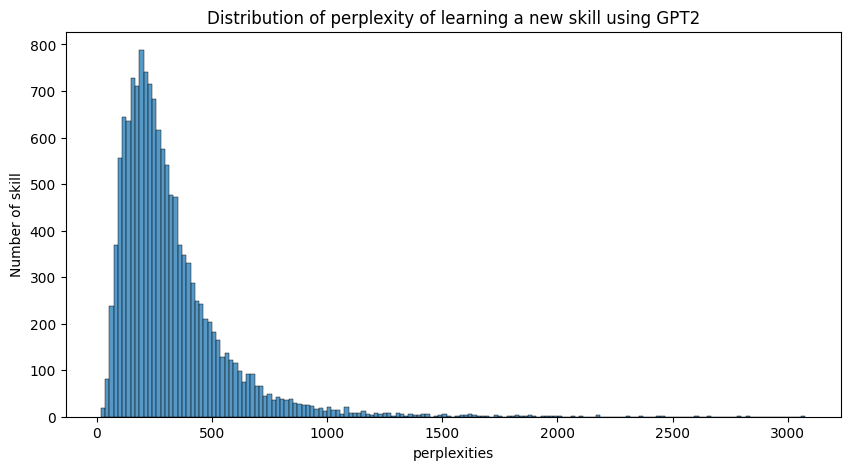

In [106]:
f, a = plt.subplots(figsize=(10, 5))
g = sns.histplot(data=F, x="perplexities")
g.set_title("Distribution of perplexity of learning a new skill using GPT2")
g.set_ylabel("Number of skill")

<ins>*Top most surpising skills to learn*</ins>

In [107]:
F.sort_values("perplexities", ascending=False).head(20)

,perplexities,input,skill
9092,3076.675293,i want to learn tally lumber,tally lumber
8523,2828.460449,i want to learn to procurement legislation,procurement legislation
11204,2790.992676,i want to learn plan beamhouse operations,plan beamhouse operations
4332,2661.844238,i want to learn to training subject expertise,training subject expertise
5831,2600.905762,i want to learn assess museum object condition,assess museum object condition
13154,2457.632812,i want to learn THC Hydra,THC Hydra
12811,2453.138184,i want to learn review completed contracts,review completed contracts
9506,2436.540771,i want to learn vacuum street debris,vacuum street debris
5001,2354.689209,i want to learn plan daily ship operations,plan daily ship operations
6250,2312.488281,i want to learn analyse drill engineering,analyse drill engineering


<ins>*Top least suprising skills to learn*</ins>

In [66]:
F.sort_values("perplexities", ascending=True).head(20)

,perplexities,input,skill
4560,18.870920,i want to learn to stay up-to-date with curren...,stay up-to-date with current events
580,22.966549,i want to learn to perform multiple tasks at t...,perform multiple tasks at the same time
5697,23.453165,i want to learn to stay up to date with social...,stay up to date with social media
13542,24.968121,i want to learn to stay up-to-date with music ...,stay up-to-date with music and video releases
5020,27.992762,i want to learn to use object-oriented program...,use object-oriented programming
6140,28.793699,i want to learn to obstetrics and gynaecology,obstetrics and gynaecology
2546,29.023550,i want to learn to play the piano,play the piano
2996,29.550997,i want to learn to stay up-to-date with latest...,stay up-to-date with latest book releases
9211,30.587366,i want to learn to make made-to-measure garments,make made-to-measure garments
1951,32.596348,i want to learn to pose in front of a camera,pose in front of a camera


In [54]:
## take the 15% of most surprising skill you would want to learn

most_surprise = F.sort_values("perplexities", ascending=False).head(int(len(F.index) * 0.15))

In [56]:
most_surprise.to_csv("generation/surprising_skills.csv") 

In [73]:
display(F[F.skill == "IBM Informix"])
display(F[F.skill == "Oracle Relational Database"])
display(F[F.skill == "SPARQL"])
display(F[F.skill == "SQL"])

,perplexities,input,skill
7250,447.313446,i want to learn IBM Informix,IBM Informix


,perplexities,input,skill
12057,321.027985,i want to learn Oracle Relational Database,Oracle Relational Database


,perplexities,input,skill
5141,98.159584,i want to learn to SPARQL,SPARQL


,perplexities,input,skill
4901,185.014954,i want to learn SQL,SQL


In [109]:
import json

with open("generation/frequency_vals.json", "w") as f:
    json.dump(F[["skill", "perplexities"]].set_index("skill").to_dict()["perplexities"], f)

In [108]:
F[F["skill"].apply(lambda x : x[0] == "C")]

,perplexities,input,skill
264,157.487595,i want to learn CryEngine,CryEngine
509,174.789398,i want to learn Cain and Abel (penetration tes...,Cain and Abel (penetration testing tool)
579,352.128784,i want to learn to Christianity,Christianity
684,117.984039,i want to learn Common Lisp,Common Lisp
1712,191.040375,i want to learn to Chinese,Chinese
2122,658.007202,i want to learn CAM software,CAM software
3186,390.947235,i want to learn to CADD software,CADD software
4023,273.830750,i want to learn Chef (tools for software confi...,Chef (tools for software configuration managem...
4124,143.108414,"i want to learn to C, which consist of : #",C#
4710,332.205811,i want to learn to Codenvy,Codenvy
